- https://realpython.com/generative-adversarial-networks/
- https://proglib.io/p/generativno-sostyazatelnaya-neyroset-vasha-pervaya-gan-model-na-pytorch-2020-08-11

In [1]:
import torch
from torch import nn

In [2]:
import math
import matplotlib.pyplot as plt

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
torch.manual_seed(111)

In [5]:
torch.__version__

'2.4.0+cu118'

In [6]:
device = "cpu"

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
device

device(type='cuda')

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [9]:
train_set = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

In [10]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

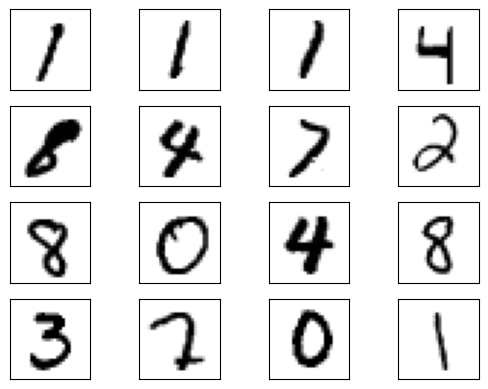

In [11]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [12]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [13]:
discriminator = Discriminator().to(device=device)

In [14]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [15]:
generator = Generator().to(device=device)

In [16]:
lr = 0.0001

In [17]:
num_epochs = 100

In [18]:
loss_function = nn.BCELoss()

In [19]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [20]:
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [21]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Данные для тренировки дискриминатора
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device)
        
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)
        
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device)
        
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Показываем loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.43612706661224365
Epoch: 0 Loss G.: 0.6370112895965576
Epoch: 1 Loss D.: 0.04157210886478424
Epoch: 1 Loss G.: 5.9300642013549805
Epoch: 2 Loss D.: 0.006384401582181454
Epoch: 2 Loss G.: 6.44345760345459
Epoch: 3 Loss D.: 0.0012581362389028072
Epoch: 3 Loss G.: 7.3121724128723145
Epoch: 4 Loss D.: 0.0008005890413187444
Epoch: 4 Loss G.: 7.660418510437012
Epoch: 5 Loss D.: 0.03970462456345558
Epoch: 5 Loss G.: 7.731256484985352
Epoch: 6 Loss D.: 0.014487754553556442
Epoch: 6 Loss G.: 5.7988128662109375
Epoch: 7 Loss D.: 0.004784806631505489
Epoch: 7 Loss G.: 5.239203929901123
Epoch: 8 Loss D.: 0.07630641758441925
Epoch: 8 Loss G.: 3.7266831398010254
Epoch: 9 Loss D.: 0.08521521836519241
Epoch: 9 Loss G.: 7.204316139221191
Epoch: 10 Loss D.: 0.019653886556625366
Epoch: 10 Loss G.: 7.251199722290039
Epoch: 11 Loss D.: 0.001443912391550839
Epoch: 11 Loss G.: 6.280819416046143
Epoch: 12 Loss D.: 0.05886215716600418
Epoch: 12 Loss G.: 5.486050605773926
Epoch: 13 Loss D.: 

In [22]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)

In [23]:
generated_samples = generator(latent_space_samples)

In [24]:
generated_samples = generated_samples.cpu().detach()

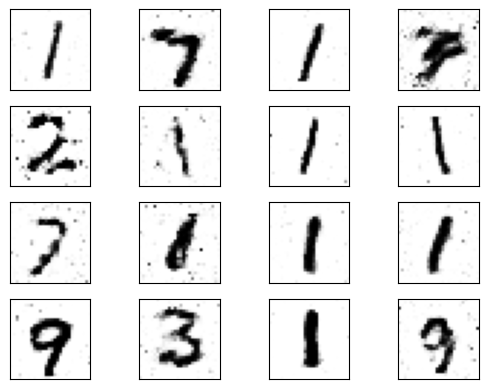

In [25]:
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])